# RLF Prediction Project

Fetch train data from github and unzip them

In [ ]:
!wget -nc https://github.com/Turkcell/ITU-AIMLin5GChallenge-2021/raw/main/RLF_Prediction_ITU_AIML_Challenge_Data/RLF_Prediction_ITU_AIML_Challenge_Data.7z
!7z x RLF_Prediction_ITU_AIML_Challenge_Data.7z -aos RLF_Prediction_ITU_AIML_Challenge_Data/RegionA.zip

--2021-09-26 15:08:32--  https://github.com/Turkcell/ITU-AIMLin5GChallenge-2021/raw/main/RLF_Prediction_ITU_AIML_Challenge_Data/RLF_Prediction_ITU_AIML_Challenge_Data.7z
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Turkcell/ITU-AIMLin5GChallenge-2021/main/RLF_Prediction_ITU_AIML_Challenge_Data/RLF_Prediction_ITU_AIML_Challenge_Data.7z [following]
--2021-09-26 15:08:32--  https://raw.githubusercontent.com/Turkcell/ITU-AIMLin5GChallenge-2021/main/RLF_Prediction_ITU_AIML_Challenge_Data/RLF_Prediction_ITU_AIML_Challenge_Data.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22740563 (22M) [appli

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries


In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import math

# Read Data 

In [ ]:
data_zip_path = "RLF_Prediction_ITU_AIML_Challenge_Data/RegionA.zip"
# Zip file reading
def read_table_from_zip(zip_path, table_name):
    with ZipFile(zip_path) as zip_file:
        with zip_file.open(table_name) as file:
            df = pd.read_csv(file, sep="\t", index_col=0)
            if "datetime" in df:
                df["datetime"] = pd.to_datetime(df["datetime"])
            return df

# Example read for RL-KPIS
rl_kpis = read_table_from_zip(data_zip_path, "rl-kpis.tsv")
print(f"rl_kpis.shape: {rl_kpis.shape}")
print(rl_kpis.datetime.min(), rl_kpis.datetime.max())
rl_kpis.head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


rl_kpis.shape: (1992986, 18)
2018-12-31 00:00:00 2020-12-25 00:00:00


,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf
0,ENK,2018-12-31,FAR,A0BE,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,1024QAM,False
1,ENK,2018-12-31,FAR,A0BI,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,1024QAM,False
2,ENK,2018-12-31,FAR,A5AB,"1,344,018",RL_;ABDV,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,512QAM,False
3,NEC,2018-12-31,FAR,A8CQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False
4,NEC,2018-12-31,FAR,A8DQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False


# Prepare Labels

In [ ]:
# Firstly, only get unique entry identifiers and RLF column.
# For rl-kpis, unique entry identifiers are 'datetime', 'site_id' and 'mlid'.
df_labels = rl_kpis[["datetime", "site_id", "mlid"]]
df_labels.head()

,datetime,site_id,mlid
0,2018-12-31,RL_;ABDV,A0BE
1,2018-12-31,RL_;ABDV,A0BI
2,2018-12-31,RL_;ABDV,A5AB
3,2018-12-31,RL_;ABDV,A8CQ
4,2018-12-31,RL_;ABDV,A8DQ


## Prepare target days (prediction days)

In [ ]:
#  Prepare columns for the following days. We will join data with these columns to find RLF
prediction_interval = 5

for i in range(prediction_interval):
  df_labels[f"T+{i+1}"] = df_labels["datetime"] + pd.DateOffset(days=i+1)
df_labels.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,datetime,site_id,mlid,T+1,T+2,T+3,T+4,T+5
0,2018-12-31,RL_;ABDV,A0BE,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05
1,2018-12-31,RL_;ABDV,A0BI,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05
2,2018-12-31,RL_;ABDV,A5AB,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05
3,2018-12-31,RL_;ABDV,A8CQ,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05
4,2018-12-31,RL_;ABDV,A8DQ,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05


## Join dataset to get RLF colunms for the target days

In [ ]:
rl_kpis_view = rl_kpis[["datetime", "site_id", "mlid", "rlf"]]
for i in range(prediction_interval):
  target_day_column_name = f"T+{i+1}"

  df_labels = df_labels.merge(rl_kpis_view, 
                  how = "left", 
                  left_on = ("site_id", "mlid", target_day_column_name),
                  right_on = ("site_id", "mlid", "datetime"),
                  suffixes = ("", "_y")
  )
  df_labels.rename(columns={"rlf": f"{target_day_column_name}_rlf"}, inplace=True)
df_labels.drop(columns=["datetime_y"], inplace=True)
df_labels.head()

,datetime,site_id,mlid,T+1,T+2,T+3,T+4,T+5,T+1_rlf,T+2_rlf,T+3_rlf,T+4_rlf,T+5_rlf
0,2018-12-31,RL_;ABDV,A0BE,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,False,False,False,False,False
1,2018-12-31,RL_;ABDV,A0BI,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,False,False,False,False,False
2,2018-12-31,RL_;ABDV,A5AB,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,False,False,False,False,False
3,2018-12-31,RL_;ABDV,A8CQ,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,False,False,False,False,False
4,2018-12-31,RL_;ABDV,A8DQ,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,False,False,False,False,False


## Finalize labels for 1-day and 5-day predictions
For each link (site_id, mlid), we found the RLF for the 5-days (T+1.. T+5) following the given day (T).
Now, we will finalize labelling

In [ ]:
# 1 day predict is equal to T+1 rlf
df_labels["1-day-predict"] = df_labels["T+1_rlf"]

# Interval predict (5-day predict) is based on T+1, T+2, T+3, T+4 and T+5
following_days_rlf_columns = [f"T+{i+1}_rlf" for i in range(prediction_interval)]

df_labels["5-day-predict"] = df_labels[following_days_rlf_columns].any(axis=1)
df_labels = df_labels[["datetime", "site_id", "mlid", "1-day-predict", "5-day-predict"]]

print(f"df_labels.shape: {df_labels.shape}")
print(f"df_labels 1-day rlf sum: {df_labels['1-day-predict'].sum()}")
print(f"df_labels 5-day rlf sum: {df_labels['5-day-predict'].sum()}")
df_labels.head()

df_labels.shape: (1992986, 5)
df_labels 1-day rlf sum: 1204
df_labels 5-day rlf sum: 5159


,datetime,site_id,mlid,1-day-predict,5-day-predict
0,2018-12-31,RL_;ABDV,A0BE,False,False
1,2018-12-31,RL_;ABDV,A0BI,False,False
2,2018-12-31,RL_;ABDV,A5AB,False,False
3,2018-12-31,RL_;ABDV,A8CQ,False,False
4,2018-12-31,RL_;ABDV,A8DQ,False,False


In [ ]:
# Now join labels with rl-kpis
rl_kpis_with_labels = rl_kpis.merge(df_labels, 
                                    how="left", 
                                    on=["datetime", "site_id", "mlid"])
rl_kpis_with_labels.head()

,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,1-day-predict,5-day-predict
0,ENK,2018-12-31,FAR,A0BE,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,1024QAM,False,False,False
1,ENK,2018-12-31,FAR,A0BI,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,1024QAM,False,False,False
2,ENK,2018-12-31,FAR,A5AB,"1,344,018",RL_;ABDV,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,512QAM,False,False,False
3,NEC,2018-12-31,FAR,A8CQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False,False,False
4,NEC,2018-12-31,FAR,A8DQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False,False,False


In [ ]:
rl_kpis_with_labels.shape

(1992986, 20)

In [ ]:
#Reading data (Data obtained from Training_final colab notebook)
rl_kpis_old_mod= pd.read_csv('/content/drive/MyDrive/FYP/rl_kpis_mod.csv', index_col=0)
forecast_wo_ohe = pd.read_csv('/content/drive/MyDrive/FYP/forecast_wo_ohe.csv',index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
rl_kpis_old_mod

,Unnamed: 0.1,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,forecast_datetime,nearest_station
0,0,ENK,2018-12-31,FAR,A0BE,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,1024QAM,False,2018-12-30,WS_18403
1,1,ENK,2018-12-31,FAR,A0BI,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,1024QAM,False,2018-12-30,WS_18403
2,2,ENK,2018-12-31,FAR,A5AB,"1,344,018",RL_;ABDV,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,512QAM,False,2018-12-30,WS_18403
3,3,NEC,2018-12-31,FAR,A8CQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False,2018-12-30,WS_18403
4,4,NEC,2018-12-31,FAR,A8DQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False,2018-12-30,WS_18403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992981,1992981,NEC,2020-12-25,NEAR,A6FD,"1,371,370",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,2048QAM*,False,2020-12-24,WS_17064
1992982,1992982,NEC,2020-12-25,NEAR,A6NA,"1,371,370",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,2048QAM*,False,2020-12-24,WS_17064
1992983,1992983,NEC,2020-12-25,FAR,A8FJ,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,2048QAM*,False,2020-12-24,WS_17064
1992984,1992984,NEC,2020-12-25,FAR,A8HV,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,2048QAM*,False,2020-12-24,WS_17064


In [ ]:
# Adding the forecast time and the predicted nearest station to rl_kpis_with_labels
# Computation of nearest station is done in Training_final
rl_kpis_with_labels['forecast_datetime'] = rl_kpis_old_mod['forecast_datetime']
rl_kpis_with_labels['nearest_station'] = rl_kpis_old_mod['nearest_station']
rl_kpis_with_labels

,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,1-day-predict,5-day-predict,forecast_datetime,nearest_station
0,ENK,2018-12-31,FAR,A0BE,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,1024QAM,False,False,False,2018-12-30,WS_18403
1,ENK,2018-12-31,FAR,A0BI,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,1024QAM,False,False,False,2018-12-30,WS_18403
2,ENK,2018-12-31,FAR,A5AB,"1,344,018",RL_;ABDV,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,512QAM,False,False,False,2018-12-30,WS_18403
3,NEC,2018-12-31,FAR,A8CQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False,False,False,2018-12-30,WS_18403
4,NEC,2018-12-31,FAR,A8DQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False,False,False,2018-12-30,WS_18403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992981,NEC,2020-12-25,NEAR,A6FD,"1,371,370",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,2048QAM*,False,NaN,False,2020-12-24,WS_17064
1992982,NEC,2020-12-25,NEAR,A6NA,"1,371,370",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-36.8,495.0,2048QAM*,False,NaN,False,2020-12-24,WS_17064
1992983,NEC,2020-12-25,FAR,A8FJ,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,2048QAM*,False,NaN,False,2020-12-24,WS_17064
1992984,NEC,2020-12-25,FAR,A8HV,"1,371,440",RL_bKZCQ,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-28.9,495.0,2048QAM*,False,NaN,False,2020-12-24,WS_17064


**Weather forecast for each station number and date time is given in 'forecast_wo_ohe'**

In [ ]:
forecast_wo_ohe

,station_no,datetime,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day1
0,WS_17047,2018-01-02,10.0,6.0,96.0,82.0,6.0,19.0,heavy rain
1,WS_17047,2018-01-03,9.0,4.0,96.0,85.0,6.0,19.0,light rain
2,WS_17047,2018-01-04,9.0,4.0,91.0,60.0,0.0,16.0,scattered clouds
3,WS_17047,2018-01-05,10.0,3.0,96.0,70.0,194.0,9.0,scattered clouds
4,WS_17047,2018-01-06,11.0,4.0,96.0,63.0,209.0,14.0,few clouds
...,...,...,...,...,...,...,...,...,...
10661,WS_19111,2020-12-19,10.0,5.0,NaN,NaN,NaN,NaN,light rain
10662,WS_19111,2020-12-20,9.0,6.0,NaN,NaN,NaN,NaN,rain
10663,WS_19111,2020-12-21,8.0,5.0,NaN,NaN,NaN,NaN,overcast clouds
10664,WS_19111,2020-12-22,8.0,2.0,NaN,NaN,NaN,NaN,light rain


In [ ]:
# Assuring the dates are timestamp type
rl_kpis_with_labels['forecast_datetime'] = [pd.Timestamp(x) for x in rl_kpis_with_labels['forecast_datetime']]
forecast_wo_ohe['datetime'] = [pd.Timestamp(x) for x in forecast_wo_ohe['datetime']]

In [ ]:
# Modify name to merge
forecast_wo_ohe.rename(columns={'datetime':'forecast_datetime', 'station_no':'nearest_station'}, inplace=True)

In [ ]:
rl_kpis_with_labels.shape

(1992986, 22)

In [ ]:
# Some values seems to be dropped
# Combining forecast data with rl_kpis values based on nearest station & forecast time
merged_df = pd.merge(rl_kpis_with_labels, forecast_wo_ohe, 
                      on=['nearest_station','forecast_datetime'],
                      validate='m:m')
merged_df

,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,1-day-predict,5-day-predict,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day1
0,ENK,2018-12-31,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,NaN,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,False,False,2018-12-30,WS_18397,8.0,-2.0,96.0,59.0,82.0,12.0,scattered clouds
1,NEC,2018-12-31,FAR,A8CO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,False,False,2018-12-30,WS_18397,8.0,-2.0,96.0,59.0,82.0,12.0,scattered clouds
2,NEC,2018-12-31,FAR,A8DO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,False,False,2018-12-30,WS_18397,8.0,-2.0,96.0,59.0,82.0,12.0,scattered clouds
3,ENK,2018-12-31,NEAR,A9ML,"1,346,561",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,False,False,2018-12-30,WS_18397,8.0,-2.0,96.0,59.0,82.0,12.0,scattered clouds
4,ENK,2018-12-31,FAR,A9MY,"1,350,051",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,False,False,2018-12-30,WS_18397,8.0,-2.0,96.0,59.0,82.0,12.0,scattered clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015629,ENK,2020-12-24,FAR,A7FV,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds
2015630,ENK,2020-12-24,FAR,A7YG,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds
2015631,ENK,2020-12-24,NEAR,A1TM,"304,560",RL_\K[RM,cardtype4,Enable,f5,0.0,0.0,0.0,86.4,0.0,-39.8,406.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds
2015632,ENK,2020-12-24,NEAR,A7IK,"1,345,828",RL_\K[RO,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-40.7,406.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds


In [ ]:
rl_sites = read_table_from_zip(data_zip_path, "rl-sites.tsv")

In [ ]:
## KPI Historical (one day) 
rl_kpis_history = rl_kpis_with_labels.copy()

# Dropping columns
rl_kpis_history.drop(columns = ['forecast_datetime','nearest_station'],inplace=True)

# Assuring the dates are timestamp type
rl_kpis_history['datetime'] = [pd.Timestamp(x) for x in rl_kpis_history['datetime']]

# Adding with site data
rl_kpis_history = rl_kpis_history.merge(rl_sites[['site_id','groundheight','clutter_class']], on='site_id')

# Renaming columns for merging
rl_kpis_history.columns= ['history_{}'.format(column) for column in rl_kpis_history.columns]

rl_kpis_history

,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_1-day-predict,history_5-day-predict,history_groundheight,history_clutter_class
0,ENK,2018-12-31,FAR,A0BE,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-31.0,456.0,1024QAM,False,False,False,107.9658,OPEN LAND
1,ENK,2018-12-31,FAR,A0BI,"1,349,988",RL_;ABDV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.7,456.0,1024QAM,False,False,False,107.9658,OPEN LAND
2,ENK,2018-12-31,FAR,A5AB,"1,344,018",RL_;ABDV,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-34.4,406.0,512QAM,False,False,False,107.9658,OPEN LAND
3,NEC,2018-12-31,FAR,A8CQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False,False,False,107.9658,OPEN LAND
4,NEC,2018-12-31,FAR,A8DQ,"1,351,204",RL_;ABDV,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-35.3,247.0,2048QAM*,False,False,False,107.9658,OPEN LAND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992981,ENK,2020-12-21,NEAR,A8VB,"1,394,768",RL_U7MCH,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-39.5,456.0,1024QAM,False,False,False,211.0133,AVERAGE-DENSE URBAN
1992982,ENK,2020-12-22,NEAR,A8VB,"1,394,768",RL_U7MCH,cardtype1,Enable,f3,0.0,1.0,0.0,86.4,1.0,-39.5,456.0,1024QAM,False,False,False,211.0133,AVERAGE-DENSE URBAN
1992983,ENK,2020-12-23,NEAR,A8VB,"1,394,768",RL_U7MCH,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-39.8,456.0,1024QAM,False,False,False,211.0133,AVERAGE-DENSE URBAN
1992984,ENK,2020-12-24,NEAR,A8VB,"1,394,768",RL_U7MCH,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-39.8,456.0,1024QAM,False,False,False,211.0133,AVERAGE-DENSE URBAN


In [ ]:
# Some additional values seem to be dropped
# Merging data with previous day's rl_kpis
merged_df = merged_df.merge(rl_kpis_history,left_on=['mlid','forecast_datetime'],right_on=['history_mlid','history_datetime'],validate='m:m')
merged_df

,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,1-day-predict,5-day-predict,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day1,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_1-day-predict,history_5-day-predict,history_groundheight,history_clutter_class
0,ENK,2019-01-01,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,NaN,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,ENK,2018-12-31,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,NaN,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,False,False,3.0446,OPEN LAND
1,NEC,2019-01-01,FAR,A8CO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,2048QAM*,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,NEC,2018-12-31,FAR,A8CO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,False,False,85.0143,OPEN LAND
2,NEC,2019-01-01,FAR,A8DO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,2048QAM*,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,NEC,2018-12-31,FAR,A8DO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,False,False,85.0143,OPEN LAND
3,ENK,2019-01-01,NEAR,A9ML,"1,346,561",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,ENK,2018-12-31,NEAR,A9ML,"1,346,561",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,False,False,85.0143,OPEN LAND
4,ENK,2019-01-01,FAR,A9MY,"1,350,051",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,ENK,2018-12-31,FAR,A9MY,"1,350,051",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,False,False,85.0143,OPEN LAND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988853,ENK,2020-12-24,FAR,A7FV,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds,ENK,2020-12-23,FAR,A7FV,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,False,False,160.0360,AVERAGE-DENSE URBAN
1988854,ENK,2020-12-24,FAR,A7YG,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds,ENK,2020-12-23,FAR,A7YG,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,False,False,160.0360,AVERAGE-DENSE URBAN
1988855,ENK,2020-12-24,NEAR,A1TM,"304,560",RL_\K[RM,cardtype4,Enable,f5,0.0,0.0,0.0,86.4,0.0,-39.8,406.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds,ENK,2020-12-23,NEAR,A1TM,"304,560",RL_\K[RM,cardtype4,Enable,f5,0.0,0.0,0.0,86.4,0.0,-39.8,406.0,512QAM,False,False,False,198.9911,SPARSE TREE
1988856,ENK,2020-12-24,NEAR,A7IK,"1,345,828",RL_\K[RO,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-40.7,406.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds,ENK,2020-12-23,NEAR,A7IK,"1,345,828",RL_\K[RO,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-40.7,406.0,512QAM,False,False

**On Merged dataset** \
-> Replacing NA values with mode (categorical columns) and mean (numerical columns). The mode and mean are found for each mlid unique value and replaced accordingly. \
-> Encoding all categorical features \
-> Upsampling and downsampling based on the month \

In [ ]:
merged_df

,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,1-day-predict,5-day-predict,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day1,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_1-day-predict,history_5-day-predict,history_groundheight,history_clutter_class,month
0,ENK,2019-01-01,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,NaN,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,ENK,2018-12-31,FAR,A5ZA,"1,339,074",RL_;ABTP,cardtype4,Enable,NaN,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,False,False,3.0446,OPEN LAND,1
1,NEC,2019-01-01,FAR,A8CO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,2048QAM*,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,NEC,2018-12-31,FAR,A8CO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,False,False,85.0143,OPEN LAND,1
2,NEC,2019-01-01,FAR,A8DO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,2048QAM*,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,NEC,2018-12-31,FAR,A8DO,"1,351,207",RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,False,False,85.0143,OPEN LAND,1
3,ENK,2019-01-01,NEAR,A9ML,"1,346,561",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,ENK,2018-12-31,NEAR,A9ML,"1,346,561",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,False,False,85.0143,OPEN LAND,1
4,ENK,2019-01-01,FAR,A9MY,"1,350,051",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,ENK,2018-12-31,FAR,A9MY,"1,350,051",RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,False,False,85.0143,OPEN LAND,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988853,ENK,2020-12-24,FAR,A7FV,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds,ENK,2020-12-23,FAR,A7FV,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,False,False,160.0360,AVERAGE-DENSE URBAN,12
1988854,ENK,2020-12-24,FAR,A7YG,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds,ENK,2020-12-23,FAR,A7YG,"1,366,303",RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,False,False,160.0360,AVERAGE-DENSE URBAN,12
1988855,ENK,2020-12-24,NEAR,A1TM,"304,560",RL_\K[RM,cardtype4,Enable,f5,0.0,0.0,0.0,86.4,0.0,-39.8,406.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds,ENK,2020-12-23,NEAR,A1TM,"304,560",RL_\K[RM,cardtype4,Enable,f5,0.0,0.0,0.0,86.4,0.0,-39.8,406.0,512QAM,False,False,False,198.9911,SPARSE TREE,12
1988856,ENK,2020-12-24,NEAR,A7IK,"1,345,828",RL_\K[RO,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-40.7,406.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds,ENK,2020-12-23,NEAR,A7IK,"1,345,828",RL_\K[RO,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-

In [ ]:
merged_df.dtypes

type                                     object
datetime                         datetime64[ns]
tip                                      object
mlid                                     object
mw_connection_no                         object
site_id                                  object
card_type                                object
adaptive_modulation                      object
freq_band                                object
severaly_error_second                   float64
error_second                            float64
unavail_second                          float64
avail_time                              float64
bbe                                     float64
rxlevmax                                float64
capacity                                float64
modulation                               object
rlf                                        bool
1-day-predict                            object
5-day-predict                              bool
forecast_datetime                datetim

In [ ]:
merged_df.isnull().sum()

type                                 0
datetime                             0
tip                                  0
mlid                                 0
mw_connection_no                     0
site_id                              0
card_type                            0
adaptive_modulation                  0
freq_band                        23316
severaly_error_second                0
error_second                         0
unavail_second                       0
avail_time                           0
bbe                                  0
rxlevmax                             0
capacity                           164
modulation                           0
rlf                                  0
1-day-predict                    25916
5-day-predict                        0
forecast_datetime                    0
nearest_station                      0
temp_max_day1                        0
temp_min_day1                        0
humidity_max_day1                17975
humidity_min_day1        

In [ ]:
# Check for NA values
merged_df.columns[merged_df.isnull().any()]

Index(['freq_band', 'capacity', '1-day-predict', 'humidity_max_day1',
       'humidity_min_day1', 'wind_dir_day1', 'wind_speed_day1',
       'history_freq_band', 'history_capacity', 'history_1-day-predict'],
      dtype='object')

In [ ]:
# This shows an example of a column containing NaN values
print(merged_df['capacity'].unique()) 

[ 72. 495. 456. 447. 406. 247. 407.  84. 109.  81.  77. 154. 158. 325.
 417. 200. 345.  44. 225. 369. 318. 364. 327.  88.  70. 203. 180.  95.
 150. 160.  99. 222.  92.  nan  74. 181. 126. 371. 138. 107.  97. 172.
  35.  94. 413. 204.  45.  41.  87. 256.  46. 492. 326.]


In [ ]:
print(merged_df['mw_connection_no'].unique())

['1,339,074' '1,351,207' '1,346,561' ... '1,395,426' '1,395,913'
 '1,395,915']


In [ ]:
#Comma causes issue while converting str to float
merged_df['mw_connection_no'] = merged_df['mw_connection_no'].str.replace(',','')
merged_df['history_mw_connection_no'] = merged_df['history_mw_connection_no'].str.replace(',','')

In [ ]:
# An example to find mode for a column
merged_df['freq_band'].mode()

0    f3
dtype: object

**Replacing NA values with mode (categorical columns) and mean (numerical columns). The mode and mean are found for each mlid unique value and replaced accordingly.**



In [ ]:
pct=lambda x: x.mode()
aggs = {'freq_band':pct}
mode_value=merged_df.groupby('mlid').agg(aggs)
max_mode=merged_df['freq_band'].mode()

for i in range(0,merged_df.shape[0]):
  if type(merged_df['freq_band'][i])!=str:
    if math.isnan(merged_df['freq_band'][i])==True:
      mlid_value=merged_df['mlid'][i]
      mode=mode_value.loc[mlid_value][0]
      if list(mode)==[]:
        merged_df['freq_band'][i]=max_mode[0]
      else:
        merged_df['freq_band'][i]=mode

pct = lambda x: x.mean()
aggs = {'capacity':pct}
mode_value = merged_df.groupby('mlid').agg(aggs)
max_mode = merged_df['capacity'].mode()

for i in range(0,merged_df.shape[0]):
  if type(merged_df['capacity'][i])!=str:
    if math.isnan(merged_df['capacity'][i])==True:
      mlid_value = merged_df['mlid'][i]
      mode = mode_value.loc[mlid_value][0]
      merged_df['capacity'][i]=mode


for i in range(0,merged_df.shape[0]):
  if type(merged_df['1-day-predict'][i])!=bool:
    if math.isnan(merged_df['1-day-predict'][i])==True:
      merged_df['1-day-predict'][i]=False

pct=lambda x: x.mean()
aggs = {'humidity_max_day1':pct}
mode_value=merged_df.groupby('mlid').agg(aggs)
for i in range(0,merged_df.shape[0]):
  if type(merged_df['humidity_max_day1'][i])!=float:
    if math.isnan(merged_df['humidity_max_day1'][i])==True:
      mlid_value=merged_df['mlid'][i]
      mode=mode_value.loc[mlid_value][0]
      merged_df['humidity_max_day1'][i]=mode

pct=lambda x: x.mean()
aggs = {'humidity_min_day1':pct}
mode_value=merged_df.groupby('mlid').agg(aggs)
for i in range(0,merged_df.shape[0]):
  if type(merged_df['humidity_min_day1'][i])!=float:
    if math.isnan(merged_df['humidity_min_day1'][i])==True:
      mlid_value=merged_df['mlid'][i]
      mode=mode_value.loc[mlid_value][0]
      merged_df['humidity_min_day1'][i]=mode

pct=lambda x: x.mean()
aggs = {'wind_dir_day1':pct}
mode_value=merged_df.groupby('mlid').agg(aggs)
for i in range(0,merged_df.shape[0]):
  if type(merged_df['wind_dir_day1'][i])!=float:
    if math.isnan(merged_df['wind_dir_day1'][i])==True:
      mlid_value=merged_df['mlid'][i]
      mode=mode_value.loc[mlid_value][0]
      merged_df['wind_dir_day1'][i]=mode

pct=lambda x: x.mean()
aggs = {'wind_speed_day1':pct}
mode_value=merged_df.groupby('mlid').agg(aggs)
for i in range(0,merged_df.shape[0]):
  if type(merged_df['wind_speed_day1'][i])!=float:
    if math.isnan(merged_df['wind_speed_day1'][i])==True:
      mlid_value=merged_df['mlid'][i]
      mode=mode_value.loc[mlid_value][0]
      merged_df['wind_speed_day1'][i]=mode

pct=lambda x: x.mode()
aggs = {'history_freq_band':pct}
mode_value=merged_df.groupby('mlid').agg(aggs)
max_mode=merged_df['history_freq_band'].mode()

for i in range(0,merged_df.shape[0]):
  if type(merged_df['history_freq_band'][i])!=str:
    if math.isnan(merged_df['history_freq_band'][i])==True:
      mlid_value=merged_df['mlid'][i]
      mode=mode_value.loc[mlid_value][0]
      if list(mode)==[]:
        merged_df['history_freq_band'][i]=max_mode[0]
      else:
        merged_df['history_freq_band'][i]=mode

pct=lambda x: x.mean()
aggs = {'history_capacity':pct}
mode_value=merged_df.groupby('mlid').agg(aggs)

for i in range(0,merged_df.shape[0]):
  if type(merged_df['history_capacity'][i])!=str:
    if math.isnan(merged_df['history_capacity'][i])==True:
      mlid_value=merged_df['mlid'][i]
      mode=mode_value.loc[mlid_value][0]
      merged_df['history_capacity'][i]=mode


for i in range(0,merged_df.shape[0]):
  if type(merged_df['history_1-day-predict'][i])!=bool:
    if math.isnan(merged_df['history_1-day-predict'][i])==True:
      merged_df['history_1-day-predict'][i]=False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now NaN values have been replaced with mean/mode with respect to the 'mlid'

In [ ]:
print(merged_df['freq_band'].unique())

['f3' 'f4' 'f5' 'f2' 'f1']


In [ ]:
print(merged_df['capacity'].unique())

[ 72. 495. 456. 447. 406. 247. 407.  84. 109.  81.  77. 154. 158. 325.
 417. 200. 345.  44. 225. 369. 318. 364. 327.  88.  70. 203. 180.  95.
 150. 160.  99. 222.  92.  74. 181. 126. 371. 138. 107.  97. 172.  35.
  94. 413. 204.  45.  41.  87. 256.  46. 492. 326.]


In [ ]:
print(merged_df['history_1-day-predict'].unique())

[False True]


All NaN values have been replaced.

In [ ]:
merged_df.isnull().sum()

type                             0
datetime                         0
tip                              0
mlid                             0
mw_connection_no                 0
site_id                          0
card_type                        0
adaptive_modulation              0
freq_band                        0
severaly_error_second            0
error_second                     0
unavail_second                   0
avail_time                       0
bbe                              0
rxlevmax                         0
capacity                         0
modulation                       0
rlf                              0
1-day-predict                    0
5-day-predict                    0
forecast_datetime                0
nearest_station                  0
temp_max_day1                    0
temp_min_day1                    0
humidity_max_day1                0
humidity_min_day1                0
wind_dir_day1                    0
wind_speed_day1                  0
weather_day1        

In [ ]:
merged_df.to_csv('/content/drive/MyDrive/intermediate_removed_nan.csv', index=False)

We did not delete rows with NaN. Instead we will replace them with mean based on 'mlid' value. Create a copy called df

In [ ]:
df = merged_df.copy() 
print(merged_df.shape[0] - df.shape[0])

0


In [ ]:
df

,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,1-day-predict,5-day-predict,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day1,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_1-day-predict,history_5-day-predict,history_groundheight,history_clutter_class,month
0,ENK,2019-01-01,FAR,A5ZA,1339074,RL_;ABTP,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,ENK,2018-12-31,FAR,A5ZA,1339074,RL_;ABTP,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-39.8,72.0,128QAM,False,False,False,3.0446,OPEN LAND,1
1,NEC,2019-01-01,FAR,A8CO,1351207,RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,2048QAM*,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,NEC,2018-12-31,FAR,A8CO,1351207,RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,False,False,85.0143,OPEN LAND,1
2,NEC,2019-01-01,FAR,A8DO,1351207,RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.2,495.0,2048QAM*,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,NEC,2018-12-31,FAR,A8DO,1351207,RL_;AC?E,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-37.9,495.0,2048QAM*,False,False,False,85.0143,OPEN LAND,1
3,ENK,2019-01-01,NEAR,A9ML,1346561,RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,ENK,2018-12-31,NEAR,A9ML,1346561,RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-30.0,456.0,1024QAM,False,False,False,85.0143,OPEN LAND,1
4,ENK,2019-01-01,FAR,A9MY,1350051,RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,ENK,2018-12-31,FAR,A9MY,1350051,RL_;AC?E,cardtype1,Enable,f3,0.0,0.0,0.0,18.0,0.0,-39.8,456.0,1024QAM,False,False,False,85.0143,OPEN LAND,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988853,ENK,2020-12-24,FAR,A7FV,1366303,RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds,ENK,2020-12-23,FAR,A7FV,1366303,RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,False,False,160.0360,AVERAGE-DENSE URBAN,12
1988854,ENK,2020-12-24,FAR,A7YG,1366303,RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds,ENK,2020-12-23,FAR,A7YG,1366303,RL_\K[MV,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-30.4,413.0,512QAM,False,False,False,160.0360,AVERAGE-DENSE URBAN,12
1988855,ENK,2020-12-24,NEAR,A1TM,304560,RL_\K[RM,cardtype4,Enable,f5,0.0,0.0,0.0,86.4,0.0,-39.8,406.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds,ENK,2020-12-23,NEAR,A1TM,304560,RL_\K[RM,cardtype4,Enable,f5,0.0,0.0,0.0,86.4,0.0,-39.8,406.0,512QAM,False,False,False,198.9911,SPARSE TREE,12
1988856,ENK,2020-12-24,NEAR,A7IK,1345828,RL_\K[RO,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-40.7,406.0,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85.0,68.0,238.0,11.0,scattered clouds,ENK,2020-12-23,NEAR,A7IK,1345828,RL_\K[RO,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-40.7,406.0,512QAM,False,False,False,107.0290,INDUSTRIAL & COMMERCIAL,12


In [ ]:
df.dtypes

type                                     object
datetime                         datetime64[ns]
tip                                      object
mlid                                     object
mw_connection_no                         object
site_id                                  object
card_type                                object
adaptive_modulation                      object
freq_band                                object
severaly_error_second                   float64
error_second                            float64
unavail_second                          float64
avail_time                              float64
bbe                                     float64
rxlevmax                                float64
capacity                                float64
modulation                               object
rlf                                        bool
1-day-predict                            object
5-day-predict                              bool
forecast_datetime                datetim

In [ ]:
df.columns[df.isnull().any()]

Index([], dtype='object')

*Dealing* with month's distribution

In [ ]:
# Ensuring 'month' is in date-time format
merged_df['month'] = [pd.Timestamp(x).month for x in merged_df['datetime']]

In [ ]:
df['month'].value_counts()

7     180034
5     176615
3     176131
11    174675
1     172159
8     170848
9     170555
6     165888
10    164402
12    153699
2     141998
4     141854
Name: month, dtype: int64

In [ ]:
# Months distribution
from collections import Counter
print(pd.DataFrame.from_dict(Counter(df['month']), orient='index').sort_values(by=0))
month_dist = dict(Counter(df['month']))
print(month_dist)

         0
4   141854
2   141998
12  153699
10  164402
6   165888
9   170555
8   170848
1   172159
11  174675
3   176131
5   176615
7   180034
{1: 172159, 2: 141998, 3: 176131, 4: 141854, 5: 176615, 6: 165888, 7: 180034, 8: 170848, 9: 170555, 10: 164402, 11: 174675, 12: 153699}


In [ ]:
from statistics import mean 
middle_ground = mean([month_dist[k] for k in month_dist.keys() if k in [6,10,9,8]])
middle_ground = int(round(middle_ground, -1))
print(middle_ground)

167920


In [ ]:
# Downsampling 
import copy
sampled_df = copy.deepcopy(df.loc[[x in [6,10,9,8] for x in df['month']]])
for m in [1,3,11,5,7]:
  temp = df.loc[df['month'] == m]
  temp = temp.sample(middle_ground)
  sampled_df = pd.concat([sampled_df, temp], axis = 0)

In [ ]:
# Upsampling December - NAIVE APPROACH
for m in [4,2,12]:
  temp = df.loc[df['month'] == m]
  temp = temp.sample(n=middle_ground, replace=True)
  sampled_df = pd.concat([sampled_df, temp], axis = 0)

In [ ]:
Counter(sampled_df['month'])

Counter({1: 167920,
         2: 167920,
         3: 167920,
         4: 167920,
         5: 167920,
         6: 165888,
         7: 167920,
         8: 170848,
         9: 170555,
         10: 164402,
         11: 167920,
         12: 167920})

In [ ]:
df.to_csv('/content/drive/MyDrive/FYP/new_preprocessed_data.csv')

# Model Training



In [ ]:
df= pd.read_csv('/content/drive/MyDrive/FYP/new_preprocessed_data.csv', index_col=0)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16,25,26,27,28,45,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
# Keeping the mlids of troublesome links.
trouble_links = df[df['rlf'] == True]['mlid'].unique()
df = df[df['mlid'].isin(trouble_links)].copy()
df=df.reset_index()

In [ ]:
df

,index,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,1-day-predict,5-day-predict,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day1,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_1-day-predict,history_5-day-predict,history_groundheight,history_clutter_class,month
0,13,NEC,2019-01-01,FAR,A5DM,"1,344,257",RL_;APKK,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-32.4,495.0,2048QAM*,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,NEC,2018-12-31,FAR,A5DM,"1,344,257",RL_;APKK,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-33.1,495.0,2048QAM*,False,False,False,155.0398,OPEN LAND,1
1,16,NEC,2019-01-01,FAR,A5LM,"1,344,257",RL_;APKK,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-32.4,495.0,2048QAM*,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,NEC,2018-12-31,FAR,A5LM,"1,344,257",RL_;APKK,cardtype5,Enable,f4,0.0,0.0,0.0,86.4,0.0,-33.1,495.0,2048QAM*,False,False,False,155.0398,OPEN LAND,1
2,23,NEC,2019-01-01,FAR,A8FQ,"1,351,205",RL_J;ZN>,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-33.6,495.0,2048QAM*,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,NEC,2018-12-31,FAR,A8FQ,"1,351,205",RL_J;ZN>,cardtype5,Enable,f3,0.0,0.0,0.0,86.4,0.0,-33.8,495.0,2048QAM*,False,False,False,45.0443,OPEN LAND,1
3,33,ENK,2019-01-01,NEAR,A5SM,"151,970",RL_JODSV,cardtype4,Enable,f4,0.0,0.0,0.0,86.4,0.0,-40.4,406.0,512QAM(QO),False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,ENK,2018-12-31,NEAR,A5SM,"151,970",RL_JODSV,cardtype4,Enable,f4,0.0,0.0,0.0,86.4,0.0,-40.4,406.0,512QAM(QO),False,False,False,164.0174,DENSE TREE,1
4,34,NEC,2019-01-01,FAR,A0AY,"144,879",RL_KJMRM,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-43.0,247.0,2048QAM*,False,False,False,2018-12-31,WS_18397,7.0,2.0,93.0,68.0,62.0,18.0,overcast clouds,NEC,2018-12-31,FAR,A0AY,"144,879",RL_KJMRM,cardtype5,Enable,f2,0.0,0.0,0.0,86.4,0.0,-43.1,247.0,2048QAM*,False,False,False,370.0345,INDUSTRIAL & COMMERCIAL,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434565,1988843,ENK,2020-12-24,FAR,A8VC,"1,361,978",RL_\K[ME,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-42.9,97,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85,68,238,11,scattered clouds,ENK,2020-12-23,FAR,A8VC,"1,361,978",RL_\K[ME,cardtype1,Enable,f3,0.0,0.0,0.0,86.4,0.0,-42.9,97,512QAM,False,False,False,116.0066,INDUSTRIAL & COMMERCIAL,12
434566,1988851,ENK,2020-12-24,FAR,A8JL,"1,368,180",RL_\K[MQ,cardtype4,Enable,f3,0.0,0.0,0.0,86.4,0.0,-41.3,180,256QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85,68,238,11,scattered clouds,ENK,2020-12-23,FAR,A8JL,"1,368,180",RL_\K[MQ,cardtype4,Enable,f3,1.0,3.0,0.0,86.4,19.0,-41.3,180,256QAM,False,False,False,191.0284,OPEN IN URBAN,12
434567,1988852,ENK,2020-12-24,FAR,A8MO,"1,387,917",RL_\K[MQ,cardtype2,Disable,f3,0.0,0.0,0.0,86.4,0.0,-39.8,35,128QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85,68,238,11,scattered clouds,ENK,2020-12-23,FAR,A8MO,"1,387,917",RL_\K[MQ,cardtype2,Disable,f3,0.0,0.0,0.0,86.4,0.0,-39.8,35,128QAM,False,False,False,191.0284,OPEN IN URBAN,12
434568,1988855,ENK,2020-12-24,NEAR,A1TM,"304,560",RL_\K[RM,cardtype4,Enable,f5,0.0,0.0,0.0,86.4,0.0,-39.8,406,512QAM,False,False,False,2020-12-23,WS_17063,14.0,6.0,85,68,238,11,scattered clouds,ENK,2020-12-23,NEAR,A1TM,"304,560",RL_\K[RM,cardtype4,Enab

In [ ]:
df.dtypes

index                              int64
type                              object
datetime                          object
tip                               object
mlid                              object
mw_connection_no                  object
site_id                           object
card_type                         object
adaptive_modulation               object
freq_band                         object
severaly_error_second            float64
error_second                     float64
unavail_second                   float64
avail_time                       float64
bbe                              float64
rxlevmax                         float64
capacity                          object
modulation                        object
rlf                                 bool
1-day-predict                     object
5-day-predict                       bool
forecast_datetime                 object
nearest_station                   object
temp_max_day1                    float64
temp_min_day1   

Even though NaN values have been replaced, some cells still contain 'none'. These values are replaced by mean or mode or by false for boolean type columns. After replacement, the boolean columns are converted into 'bool' type and the categorical columns are encoded.

In [ ]:
for i in range(0,df.shape[0]):
  if (df['1-day-predict'][i])=='True':
    df['1-day-predict'][i]=True
  else:
    df['1-day-predict'][i]=False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
 df['1-day-predict'].unique()

array([False, True], dtype=object)

In [ ]:
df['1-day-predict']=df['1-day-predict'].astype('bool')

In [ ]:
 df['history_1-day-predict'].unique()

array(['False', 'True', False, True, 'None'], dtype=object)

In [ ]:
for i in range(0,df.shape[0]):
  if (df['history_1-day-predict'][i])=='True':
    df['history_1-day-predict'][i]=True
  elif (df['history_1-day-predict'][i])=='False' or (df['history_1-day-predict'][i])=='None':
    df['history_1-day-predict'][i]=False
  else:
    continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df['history_1-day-predict']=df['history_1-day-predict'].astype('bool')

In [ ]:
df['history_1-day-predict'].unique()

array([False,  True])

In [ ]:
max_mode=df['wind_speed_day1'].mode()
for i in range(0, df.shape[0]):
  if df['wind_speed_day1'][i]=='None':
      df['wind_speed_day1'][i]=max_mode[0]

max_mode=df['freq_band'].mode()
for i in range(0, df.shape[0]):
  if df['freq_band'][i]=='None':
      df['freq_band'][i]=max_mode[0]

max_mode=df['history_freq_band'].mode()
for i in range(0, df.shape[0]):
  if df['history_freq_band'][i]=='None':
      df['history_freq_band'][i]=max_mode[0]

max_mode=df['humidity_max_day1'].mode()
for i in range(0, df.shape[0]):
  if df['humidity_max_day1'][i]=='None':
      df['humidity_max_day1'][i]=max_mode[0]
max_mode=df['humidity_min_day1'].mode()
for i in range(0, df.shape[0]):
  if df['humidity_min_day1'][i]=='None':
      df['humidity_min_day1'][i]=max_mode[0]

max_mode=df['wind_dir_day1'].mode()
for i in range(0, df.shape[0]):
  if df['wind_dir_day1'][i]=='None':
      df['wind_dir_day1'][i]=max_mode[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipy

In [ ]:
df['wind_dir_day1']=df['wind_dir_day1'].astype('float')
df['wind_speed_day1']=df['wind_speed_day1'].astype('float')
df['humidity_min_day1']=df['humidity_min_day1'].astype('float')
df['humidity_max_day1']=df['humidity_max_day1'].astype('float')
df['capacity']=df['capacity'].astype('float')
df['history_capacity']=df['history_capacity'].astype('float')
df['freq_band'] = pd.factorize(df['freq_band'])[0]
df['history_freq_band'] = pd.factorize(df['history_freq_band'])[0]
df['weather_day1'] = pd.factorize(df['weather_day1'])[0]
df['nearest_station'] = pd.factorize(df['nearest_station'])[0]
df['type'] = pd.factorize(df['type'])[0]
df['history_type'] = pd.factorize(df['history_type'])[0]
df['tip'] = pd.factorize(df['tip'])[0]
df['history_tip'] = pd.factorize(df['history_tip'])[0]
df['mlid'] = pd.factorize(df['mlid'])[0]
df['history_mlid'] = pd.factorize(df['history_mlid'])[0]
df['mw_connection_no'] = pd.factorize(df['mw_connection_no'])[0]
df['history_mw_connection_no'] = pd.factorize(df['history_mw_connection_no'])[0]
df['site_id'] = pd.factorize(df['site_id'])[0]
df['history_site_id'] = pd.factorize(df['history_site_id'])[0]
df['card_type'] = pd.factorize(df['card_type'])[0]
df['history_card_type'] = pd.factorize(df['history_card_type'])[0]
df['history_card_type'] = pd.factorize(df['history_card_type'])[0]
df['history_adaptive_modulation'] = pd.factorize(df['history_adaptive_modulation'])[0]
df['adaptive_modulation'] = pd.factorize(df['adaptive_modulation'])[0]
df['history_clutter_class'] = pd.factorize(df['history_clutter_class'])[0]
df['modulation'] = pd.factorize(df['modulation'])[0]
df['history_modulation'] = pd.factorize(df['history_modulation'])[0]
df['month'] = pd.factorize(df['month'])[0]

In [ ]:
df.dtypes

index                              int64
type                               int64
datetime                          object
tip                                int64
mlid                               int64
mw_connection_no                   int64
site_id                            int64
card_type                          int64
adaptive_modulation                int64
freq_band                          int64
severaly_error_second            float64
error_second                     float64
unavail_second                   float64
avail_time                       float64
bbe                              float64
rxlevmax                         float64
capacity                         float64
modulation                         int64
rlf                                 bool
1-day-predict                       bool
5-day-predict                       bool
forecast_datetime                 object
nearest_station                    int64
temp_max_day1                    float64
temp_min_day1   

In [ ]:
df

,index,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,1-day-predict,5-day-predict,forecast_datetime,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day1,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_1-day-predict,history_5-day-predict,history_groundheight,history_clutter_class,month
0,13,0,2019-01-01,0,0,0,0,0,0,0,0.0,0.0,0.0,86.4,0.0,-32.4,495.0,0,False,False,False,2018-12-31,0,7.0,2.0,93.0,68.0,62.0,18.0,0,0,2018-12-31,0,0,0,0,0,0,0,0.0,0.0,0.0,86.4,0.0,-33.1,495.0,0,False,False,False,155.0398,0,0
1,16,0,2019-01-01,0,1,0,0,0,0,0,0.0,0.0,0.0,86.4,0.0,-32.4,495.0,0,False,False,False,2018-12-31,0,7.0,2.0,93.0,68.0,62.0,18.0,0,0,2018-12-31,0,1,0,0,0,0,0,0.0,0.0,0.0,86.4,0.0,-33.1,495.0,0,False,False,False,155.0398,0,0
2,23,0,2019-01-01,0,2,1,1,0,0,1,0.0,0.0,0.0,86.4,0.0,-33.6,495.0,0,False,False,False,2018-12-31,0,7.0,2.0,93.0,68.0,62.0,18.0,0,0,2018-12-31,0,2,1,1,0,0,1,0.0,0.0,0.0,86.4,0.0,-33.8,495.0,0,False,False,False,45.0443,0,0
3,33,1,2019-01-01,1,3,2,2,1,0,0,0.0,0.0,0.0,86.4,0.0,-40.4,406.0,1,False,False,False,2018-12-31,0,7.0,2.0,93.0,68.0,62.0,18.0,0,1,2018-12-31,1,3,2,2,1,0,0,0.0,0.0,0.0,86.4,0.0,-40.4,406.0,1,False,False,False,164.0174,1,0
4,34,0,2019-01-01,0,4,3,3,0,0,2,0.0,0.0,0.0,86.4,0.0,-43.0,247.0,0,False,False,False,2018-12-31,0,7.0,2.0,93.0,68.0,62.0,18.0,0,0,2018-12-31,0,4,3,3,0,0,2,0.0,0.0,0.0,86.4,0.0,-43.1,247.0,0,False,False,False,370.0345,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434565,1988843,1,2020-12-24,0,588,361,405,3,0,1,0.0,0.0,0.0,86.4,0.0,-42.9,97.0,2,False,False,False,2020-12-23,8,14.0,6.0,85.0,68.0,238.0,11.0,6,1,2020-12-23,0,588,361,405,3,0,1,0.0,0.0,0.0,86.4,0.0,-42.9,97.0,2,False,False,False,116.0066,2,11
434566,1988851,1,2020-12-24,0,589,367,406,1,0,1,0.0,0.0,0.0,86.4,0.0,-41.3,180.0,3,False,False,False,2020-12-23,8,14.0,6.0,85.0,68.0,238.0,11.0,6,1,2020-12-23,0,589,367,406,1,0,1,1.0,3.0,0.0,86.4,19.0,-41.3,180.0,3,False,False,False,191.0284,11,11
434567,1988852,1,2020-12-24,0,683,462,406,2,1,1,0.0,0.0,0.0,86.4,0.0,-39.8,35.0,5,False,False,False,2020-12-23,8,14.0,6.0,85.0,68.0,238.0,11.0,6,1,2020-12-23,0,683,462,406,2,1,1,0.0,0.0,0.0,86.4,0.0,-39.8,35.0,5,False,False,False,191.0284,11,11
434568,1988855,1,2020-12-24,1,590,369,407,1,0,3,0.0,0.0,0.0,86.4,0.0,-39.8,406.0,2,False,False,False,2020-12-23,8,14.0,6.0,85.0,68.0,238.0,11.0,6,1,2020-12-23,1,590,369,407,1,0,3,0.0,0.0,0.0,86.4,0.0,-39.8,406.0,2,False,False,False,198.9911,12,11


In [ ]:
df.to_csv('/content/drive/MyDrive/FYP/new_preprocessed_data_1.csv')

In [ ]:
df.columns[df.isnull().any()]

Index([], dtype='object')

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/FYP/new_preprocessed_data_1.csv', index_col=0)

## **Train/test split**

*   The split is made per each month

First model is for one-day prediction. 

In [ ]:
# To split the dataframe into train set and test set by some column
def train_eval_split(df: pd.DataFrame, column: str, train_ratio: float = 0.7):
  if train_ratio > 1:
    raise ValueError(f'train ration cannot be {train_ratio}')
    
  train_df = pd.DataFrame([], columns=df.columns)
  test_df = pd.DataFrame([], columns=df.columns)
  for c in set(df[column]):
    temp = df.loc[df[column] == c]
    #temp = temp.sort_values(by='datetime').reset_index(drop=True)
    temp = temp.sample(temp.shape[0]).reset_index(drop=True)

    l = temp.shape[0]
    n = int(l * train_ratio)

    train_df = pd.concat([train_df, temp.iloc[:n]], axis=0)
    test_df = pd.concat([test_df, temp.iloc[n:]], axis=0)

  return train_df, test_df

In [ ]:
train_df, test_df = train_eval_split(df=df, column='month')
to_drop = ['history_datetime','forecast_datetime','datetime','5-day-predict']          
train_df = train_df.drop(columns=to_drop)
test_df = test_df.drop(columns=to_drop)

# Select the target
target = '1-day-predict'
candidates = ['1-day-predict', 'bbe', 'capacity']

train_df = train_df.drop(columns=[c for c in candidates if c != target])
test_df = test_df.drop(columns=[c for c in candidates if c != target])

all_features = [c for c in train_df.columns if c != target]

In [ ]:
x = train_df.loc[:, train_df.columns != target].values
y = train_df.loc[:, train_df.columns == target].values.ravel()

x = np.array(x).astype(float)
y = np.array(y).astype(float)

x_test = test_df.loc[:, test_df.columns != target].values
y_test = test_df.loc[:, test_df.columns == target].values.ravel()

x_test = np.array(x_test).astype(float)
y_test = np.array(y_test).astype(float)

In [ ]:
x.shape

(304193, 46)

[Text(122.76, 203.85, 'X[42] <= 0.5\ngini = 0.311\nsamples = 304193\nvalue = [3034.63, 722.7]'),
 Text(100.44, 176.67000000000002, 'gini = 0.0\nsamples = 300554\nvalue = [3005.54, 0.0]'),
 Text(145.08, 176.67000000000002, 'X[15] <= 0.5\ngini = 0.074\nsamples = 3639\nvalue = [29.09, 722.7]'),
 Text(66.96000000000001, 149.49, 'X[19] <= 67.5\ngini = 0.055\nsamples = 2766\nvalue = [20.56, 702.9]'),
 Text(44.64, 122.31, 'gini = 0.0\nsamples = 33\nvalue = [0.33, 0.0]'),
 Text(89.28, 122.31, 'X[21] <= 357.5\ngini = 0.054\nsamples = 2733\nvalue = [20.23, 702.9]'),
 Text(66.96000000000001, 95.13, 'X[36] <= 589.5\ngini = 0.054\nsamples = 2713\nvalue = [20.03, 702.9]'),
 Text(44.64, 67.94999999999999, 'X[35] <= 15.75\ngini = 0.054\nsamples = 2699\nvalue = [19.89, 702.9]'),
 Text(22.32, 40.77000000000001, 'gini = 0.0\nsamples = 14\nvalue = [0.14, 0.0]'),
 Text(66.96000000000001, 40.77000000000001, 'X[23] <= 4.5\ngini = 0.053\nsamples = 2685\nvalue = [19.75, 702.9]'),
 Text(44.64, 13.59000000000000

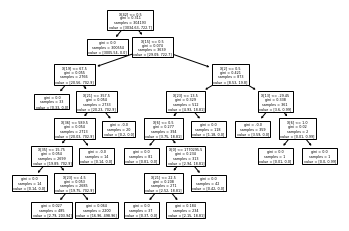

In [ ]:
# use decision tree
from sklearn import tree
dtree_clf_1_wp = tree.DecisionTreeClassifier(max_depth=7, random_state=1555,class_weight={0:0.01,1:0.99})
dtree_clf_1_wp.fit(x,y)

tree.plot_tree(dtree_clf_1_wp)

In [ ]:
## Performance Measurement for Classification Tree. 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pandas import Series

#1. Resubstitution Error.
resuberror = accuracy_score(y, dtree_clf_1_wp.predict(x)) 
print("resuberror= %0.4f" % (1- resuberror))

#2. Cross-Validation Error (Kfold = 10).
print("random_state = " + str(dtree_clf_1_wp.random_state))
cverror = cross_val_score(dtree_clf_1_wp, x, y,cv=10, scoring='accuracy')
print("cverror= %0.4f (+/- %0.4f)" % (1-cverror.mean(), cverror.std()))

# Generalization error.
testerror = accuracy_score(y_test, dtree_clf_1_wp.predict(x_test))
print("testerror= %0.4f" % (1-testerror))
print('\nConfusion matrix for test set:') 
print(confusion_matrix(y_test, dtree_clf_1_wp.predict(x_test)))
class_report = classification_report(y_test, dtree_clf_1_wp.predict(x_test))
class_report = Series(class_report.splitlines()).str.rsplit(n= 4, expand=True).dropna()
class_report.columns = ['Class', 'precision', 'recall', 'f1-score', 'support']
class_report = class_report.reset_index()
del class_report['index']
print('\nClassification report for test set:')
print(class_report) 

# Computation time.
print('\nComputation time per sample:')
%timeit dtree_clf_1_wp.predict(x_test[:1,:])

resuberror= 0.0072
random_state = 1555
cverror= 0.0070 (+/- 0.0038)
testerror= 0.0072

Confusion matrix for test set:
[[129120    936]
 [     8    313]]

Classification report for test set:
          Class precision recall f1-score support
0           0.0      1.00   0.99     1.00  130056
1           1.0      0.25   0.98     0.40     321
2     macro avg      0.63   0.98     0.70  130377
3  weighted avg      1.00   0.99     0.99  130377

Computation time per sample:
10000 loops, best of 5: 85.5 µs per loop


In [ ]:
'''
Source: 
https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
'''
def tree_to_rules(dt, all_features):
  tree_ = dt.tree_
  feature_names = [
                   all_features[i] if i != tree._tree.TREE_UNDEFINED else 'undefined' 
                   for i in tree_.feature
  ]

  def recurse(node, depth):
    indent = "- " * depth
    if tree_.feature[node] != tree._tree.TREE_UNDEFINED:
      name = feature_names[node]
      threshold = tree_.threshold[node]
      print(f"{indent}if {name} <= {threshold:.2f}:")
      recurse(tree_.children_left[node], depth + 1)
      print(f"{indent}else:  # if {name} > {threshold:.2f}")
      recurse(tree_.children_right[node], depth + 1)
    else:
      print(f"{indent}return >>> {tree_.value[node]}")

  recurse(0, 0)

tree_to_rules(dtree_clf_1_wp, all_features)

if history_5-day-predict <= 0.50:
- return >>> [[3005.54000002    0.        ]]
else:  # if history_5-day-predict > 0.50
- if rlf <= 0.50:
- - if humidity_max_day1 <= 67.50:
- - - return >>> [[0.33 0.  ]]
- - else:  # if humidity_max_day1 > 67.50
- - - if wind_dir_day1 <= 357.50:
- - - - if history_bbe <= 589.50:
- - - - - if history_avail_time <= 15.75:
- - - - - - return >>> [[0.14 0.  ]]
- - - - - else:  # if history_avail_time > 15.75
- - - - - - if weather_day1 <= 4.50:
- - - - - - - return >>> [[  2.79 203.94]]
- - - - - - else:  # if weather_day1 > 4.50
- - - - - - - return >>> [[ 16.96 498.96]]
- - - - else:  # if history_bbe > 589.50
- - - - - return >>> [[0.14 0.  ]]
- - - else:  # if wind_dir_day1 > 357.50
- - - - return >>> [[0.2 0. ]]
- else:  # if rlf > 0.50
- - if tip <= 0.50:
- - - if weather_day1 <= 13.50:
- - - - if card_type <= 0.50:
- - - - - return >>> [[0.81 0.  ]]
- - - - else:  # if card_type > 0.50
- - - - - if index <= 1770295.50:
- - - - - - if wind_dir_day1 <

Following is the second model for 5-day prediction

In [ ]:
train_df, test_df = train_eval_split(df=df, column='month')
to_drop = [ 'history_datetime','forecast_datetime','datetime','1-day-predict']          
train_df = train_df.drop(columns=to_drop)
test_df = test_df.drop(columns=to_drop)

# Select the target
target = '5-day-predict'
candidates = ['5-day-predict', 'bbe', 'capacity']

train_df = train_df.drop(columns=[c for c in candidates if c != target])
test_df = test_df.drop(columns=[c for c in candidates if c != target])

all_features = [c for c in train_df.columns if c != target]

In [ ]:
x = train_df.loc[:, train_df.columns != target].values
y = train_df.loc[:, train_df.columns == target].values.ravel()

x = np.array(x).astype(float)
y = np.array(y).astype(float)

x_test = test_df.loc[:, test_df.columns != target].values
y_test = test_df.loc[:, test_df.columns == target].values.ravel()

x_test = np.array(x_test).astype(float)
y_test = np.array(y_test).astype(float)

[Text(222.98203125, 203.85, 'X[42] <= 0.5\ngini = 0.498\nsamples = 304193\nvalue = [3007.42, 3416.49]'),
 Text(142.5515625, 176.67000000000002, 'X[17] <= 23.75\ngini = 0.301\nsamples = 300621\nvalue = [2999.35, 679.14]'),
 Text(71.36919642857143, 149.49, 'X[7] <= 0.5\ngini = 0.189\nsamples = 175613\nvalue = [1754.03, 207.9]'),
 Text(41.85, 122.31, 'X[36] <= 5208.5\ngini = 0.14\nsamples = 150064\nvalue = [1499.4, 122.76]'),
 Text(23.914285714285715, 95.13, 'X[0] <= 889120.0\ngini = 0.137\nsamples = 150013\nvalue = [1498.92, 119.79]'),
 Text(11.957142857142857, 67.94999999999999, 'X[0] <= 888921.5\ngini = 0.203\nsamples = 58101\nvalue = [580.25, 75.24]'),
 Text(5.978571428571429, 40.77000000000001, 'X[23] <= 7.5\ngini = 0.186\nsamples = 58072\nvalue = [580.04, 67.32]'),
 Text(2.9892857142857143, 13.590000000000003, 'gini = 0.129\nsamples = 38482\nvalue = [384.53, 28.71]'),
 Text(8.967857142857143, 13.590000000000003, 'gini = 0.275\nsamples = 19590\nvalue = [195.51, 38.61]'),
 Text(17.935

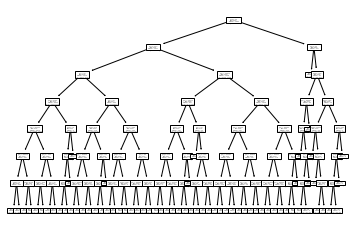

In [ ]:
# use decision tree
from sklearn import tree
dtree_clf_5_wp = tree.DecisionTreeClassifier(max_depth=7, random_state=1555,class_weight={0:0.01,1:0.99})
dtree_clf_5_wp.fit(x,y)

tree.plot_tree(dtree_clf_5_wp)

In [ ]:
## Performance Measurement for Classification Tree. 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pandas import Series

#1. Resubstitution Error.
resuberror = accuracy_score(y, dtree_clf_5_wp.predict(x)) 
print("resuberror= %0.4f" % (1- resuberror))

#2. Cross-Validation Error (Kfold = 10).
print("random_state = " + str(dtree_clf_5_wp.random_state))
cverror = cross_val_score(dtree_clf_5_wp, x, y,cv=10, scoring='accuracy')
print("cverror= %0.4f (+/- %0.4f)" % (1-cverror.mean(), cverror.std()))

# Generalization error.
testerror = accuracy_score(y_test, dtree_clf_5_wp.predict(x_test))
print("testerror= %0.4f" % (1-testerror))
print('\nConfusion matrix for test set:') 
print(confusion_matrix(y_test, dtree_clf_5_wp.predict(x_test)))
class_report = classification_report(y_test, dtree_clf_5_wp.predict(x_test))
class_report = Series(class_report.splitlines()).str.rsplit(n= 4, expand=True).dropna()
class_report.columns = ['Class', 'precision', 'recall', 'f1-score', 'support']
class_report = class_report.reset_index()
del class_report['index']
print('\nClassification report for test set:')
print(class_report) 

# Computation time.
print('\nComputation time per sample:')
%timeit dtree_clf_5_wp.predict(x_test[:1,:])

resuberror= 0.0250
random_state = 1555
cverror= 0.0492 (+/- 0.0526)
testerror= 0.0251

Confusion matrix for test set:
[[125767   3090]
 [   178   1342]]

Classification report for test set:
          Class precision recall f1-score support
0           0.0      1.00   0.98     0.99  128857
1           1.0      0.30   0.88     0.45    1520
2     macro avg      0.65   0.93     0.72  130377
3  weighted avg      0.99   0.97     0.98  130377

Computation time per sample:
10000 loops, best of 5: 86.2 µs per loop


# Validation Data Usage

## Read Validation Data

In [ ]:
# Download test data from github
!wget -nc https://github.com/Turkcell/ITU-AIMLin5GChallenge-2021/raw/main/RLF_Prediction_ITU_AIML_Challenge_Data/RLF_Prediction_ITU_AIML_Challenge_Test_20210125.7z
!7z x RLF_Prediction_ITU_AIML_Challenge_Test_20210125.7z -aos RLF_Prediction_ITU_AIML_Challenge_Test_20210125/


--2021-09-26 11:13:46--  https://github.com/Turkcell/ITU-AIMLin5GChallenge-2021/raw/main/RLF_Prediction_ITU_AIML_Challenge_Data/RLF_Prediction_ITU_AIML_Challenge_Test_20210125.7z
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Turkcell/ITU-AIMLin5GChallenge-2021/main/RLF_Prediction_ITU_AIML_Challenge_Data/RLF_Prediction_ITU_AIML_Challenge_Test_20210125.7z [following]
--2021-09-26 11:13:46--  https://raw.githubusercontent.com/Turkcell/ITU-AIMLin5GChallenge-2021/main/RLF_Prediction_ITU_AIML_Challenge_Data/RLF_Prediction_ITU_AIML_Challenge_Test_20210125.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

In [ ]:
data_zip_path = "./RLF_Prediction_ITU_AIML_Challenge_Test_20210125/RegionA_test_20210125.zip"

# Example read for RL-KPIS
validation_rl_kpis = read_table_from_zip(data_zip_path, "rl-kpis.tsv")
print(f"validation_rl_kpis.shape: {validation_rl_kpis.shape}")
print(validation_rl_kpis.datetime.min(), validation_rl_kpis.datetime.max())
validation_rl_kpis.tail(5)

validation_rl_kpis.shape: (50978, 19)
2021-01-25 00:00:00 2021-02-13 00:00:00


,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,scalibility_score,capacity,modulation,rlf
50973,NEC,2021-02-13,NEAR,A6FD,1371370,RL_bKZCQ,cardtype5,Enable,f3,0,0,0.0,86400,0.0,-37.5,0.0,495,2048QAM*,False
50974,NEC,2021-02-13,NEAR,A6NA,1371370,RL_bKZCQ,cardtype5,Enable,f3,0,0,0.0,86400,0.0,-37.5,0.0,495,2048QAM*,False
50975,NEC,2021-02-13,FAR,A8FJ,1371440,RL_bKZCQ,cardtype5,Enable,f3,0,0,0.0,86400,0.0,-28.9,0.0,495,2048QAM*,False
50976,NEC,2021-02-13,FAR,A8HV,1371440,RL_bKZCQ,cardtype5,Enable,f3,0,0,0.0,86400,0.0,-28.9,0.0,495,2048QAM*,False
50977,NEC,2021-02-13,NEAR,A4ZO,1348886,RL_bLTQH,cardtype5,Enable,f3,0,0,0.0,86400,0.0,-38.3,0.0,495,2048QAM*,False


'val_df' is a pre-processed version of the validation data. The pre-processing can be viewed in 'validation_preprocess.ipynb'

In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/FYP/val_preprocessed_data.csv',index_col=False)

## Prediction Phase

In [ ]:
val_df

,Unnamed: 0,index,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,1-day-predict,1-day-predict.1,nearest_station,forecast_datetime,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day1,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_1-day-predict,history_1-day-predict.1,history_groundheight,history_clutter_class,month
0,0,0,0,2021-02-13,0,0,0,0,0,0,0,0,0,0.0,86400,0.0,-31.0,456.0,0,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,0,2021-02-12,0,0,0,0,0,0,0,0,0,0.0,86400,0.0,-31.0,456.0,0,False,False,False,107.9658,0,1
1,1,1,0,2021-02-13,0,1,0,0,0,0,0,0,0,0.0,86400,0.0,-30.7,456.0,0,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,0,2021-02-12,0,1,0,0,0,0,0,0,0,0.0,86400,0.0,-30.4,456.0,0,False,False,False,107.9658,0,1
2,2,2,0,2021-02-13,0,2,1,0,1,0,0,0,0,0.0,86400,0.0,-34.7,406.0,1,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,0,2021-02-12,0,2,1,0,1,0,0,0,0,0.0,86400,0.0,-34.4,406.0,1,False,False,False,107.9658,0,1
3,3,3,1,2021-02-13,0,3,2,0,2,0,1,0,0,86400.0,86400,0.0,-99.0,247.0,2,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,1,2021-02-12,0,3,2,0,2,0,1,0,0,86400.0,86400,0.0,-98.7,247.0,2,False,False,False,107.9658,0,1
4,4,4,1,2021-02-13,0,4,2,0,2,0,1,0,0,86400.0,86400,0.0,-99.0,247.0,2,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,1,2021-02-12,0,4,2,0,2,0,1,0,0,86400.0,86400,0.0,-98.7,247.0,2,False,False,False,107.9658,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,1815,1815,0,2021-02-13,0,1815,911,934,1,0,0,0,0,0.0,86400,0.0,-39.8,95.0,1,False,NaN,False,8,2021-02-12,7,1,63.0,52.0,39.0,24.0,0,0,2021-02-12,0,1815,911,934,1,0,0,0,0,0.0,86400,0.0,-39.8,95.0,1,False,False,False,17.0185,6,1
1816,1816,1816,0,2021-02-13,0,1816,918,934,1,0,2,0,0,0.0,86400,0.0,-39.8,406.0,1,False,NaN,False,8,2021-02-12,7,1,63.0,52.0,39.0,24.0,0,0,2021-02-12,0,1816,918,934,1,0,2,0,0,0.0,86400,0.0,-39.5,406.0,1,False,False,False,17.0185,6,1
1817,1817,1817,0,2021-02-13,0,1817,907,935,1,0,2,0,0,0.0,86400,0.0,-39.8,406.0,5,False,NaN,False,8,2021-02-12,7,1,63.0,52.0,39.0,24.0,0,0,2021-02-12,0,1817,907,935,1,0,2,0,0,0.0,86400,0.0,-39.5,406.0,5,False,False,False,8.9776,6,1
1818,1818,1818,0,2021-02-13,0,1818,901,935,0,0,0,0,0,0.0,86400,0.0,-39.5,406.0,1,False,NaN,False,8,2021-02-12,7,1,63.0,52.0,39.0,24.0,0,0,2021-02-12,0,1818,901,935,0,0,0,0,0,0.0,86400,0.0,-39.8,406.0,1,False,False,False,8.9776,6,1


In [ ]:
val_df=val_df.drop(columns=['Unnamed: 0'])

In [ ]:
val_df=val_df.rename(columns={'1-day-predict.1':'5-day-predict','history_1-day-predict.1':'histroy_5-day-predict'})

In [ ]:
val_df

,index,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,1-day-predict,5-day-predict,nearest_station,forecast_datetime,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day1,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_1-day-predict,histroy_5-day-predict,history_groundheight,history_clutter_class,month
0,0,0,2021-02-13,0,0,0,0,0,0,0,0,0,0.0,86400,0.0,-31.0,456.0,0,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,0,2021-02-12,0,0,0,0,0,0,0,0,0,0.0,86400,0.0,-31.0,456.0,0,False,False,False,107.9658,0,1
1,1,0,2021-02-13,0,1,0,0,0,0,0,0,0,0.0,86400,0.0,-30.7,456.0,0,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,0,2021-02-12,0,1,0,0,0,0,0,0,0,0.0,86400,0.0,-30.4,456.0,0,False,False,False,107.9658,0,1
2,2,0,2021-02-13,0,2,1,0,1,0,0,0,0,0.0,86400,0.0,-34.7,406.0,1,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,0,2021-02-12,0,2,1,0,1,0,0,0,0,0.0,86400,0.0,-34.4,406.0,1,False,False,False,107.9658,0,1
3,3,1,2021-02-13,0,3,2,0,2,0,1,0,0,86400.0,86400,0.0,-99.0,247.0,2,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,1,2021-02-12,0,3,2,0,2,0,1,0,0,86400.0,86400,0.0,-98.7,247.0,2,False,False,False,107.9658,0,1
4,4,1,2021-02-13,0,4,2,0,2,0,1,0,0,86400.0,86400,0.0,-99.0,247.0,2,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,1,2021-02-12,0,4,2,0,2,0,1,0,0,86400.0,86400,0.0,-98.7,247.0,2,False,False,False,107.9658,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,1815,0,2021-02-13,0,1815,911,934,1,0,0,0,0,0.0,86400,0.0,-39.8,95.0,1,False,NaN,False,8,2021-02-12,7,1,63.0,52.0,39.0,24.0,0,0,2021-02-12,0,1815,911,934,1,0,0,0,0,0.0,86400,0.0,-39.8,95.0,1,False,False,False,17.0185,6,1
1816,1816,0,2021-02-13,0,1816,918,934,1,0,2,0,0,0.0,86400,0.0,-39.8,406.0,1,False,NaN,False,8,2021-02-12,7,1,63.0,52.0,39.0,24.0,0,0,2021-02-12,0,1816,918,934,1,0,2,0,0,0.0,86400,0.0,-39.5,406.0,1,False,False,False,17.0185,6,1
1817,1817,0,2021-02-13,0,1817,907,935,1,0,2,0,0,0.0,86400,0.0,-39.8,406.0,5,False,NaN,False,8,2021-02-12,7,1,63.0,52.0,39.0,24.0,0,0,2021-02-12,0,1817,907,935,1,0,2,0,0,0.0,86400,0.0,-39.5,406.0,5,False,False,False,8.9776,6,1
1818,1818,0,2021-02-13,0,1818,901,935,0,0,0,0,0,0.0,86400,0.0,-39.5,406.0,1,False,NaN,False,8,2021-02-12,7,1,63.0,52.0,39.0,24.0,0,0,2021-02-12,0,1818,901,935,0,0,0,0,0,0.0,86400,0.0,-39.8,406.0,1,False,False,False,8.9776,6,1


In [ ]:
to_drop = [ 'history_datetime','forecast_datetime','datetime','5-day-predict']   
valid_df = val_df.drop(columns=to_drop)
# Select the target 
target = '1-day-predict'
candidates = ['1-day-predict', 'bbe', 'capacity']
valid_df = valid_df.drop(columns=[c for c in candidates if c != target])
all_features = [c for c in valid_df.columns if c != target]

In [ ]:
valid_df

,index,type,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,rxlevmax,modulation,rlf,1-day-predict,nearest_station,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day1,history_type,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_1-day-predict,histroy_5-day-predict,history_groundheight,history_clutter_class,month
0,0,0,0,0,0,0,0,0,0,0,0,0.0,86400,-31.0,0,False,NaN,0,3,1,61.0,53.0,29.0,20.0,0,0,0,0,0,0,0,0,0,0,0,0.0,86400,0.0,-31.0,456.0,0,False,False,False,107.9658,0,1
1,1,0,0,1,0,0,0,0,0,0,0,0.0,86400,-30.7,0,False,NaN,0,3,1,61.0,53.0,29.0,20.0,0,0,0,1,0,0,0,0,0,0,0,0.0,86400,0.0,-30.4,456.0,0,False,False,False,107.9658,0,1
2,2,0,0,2,1,0,1,0,0,0,0,0.0,86400,-34.7,1,False,NaN,0,3,1,61.0,53.0,29.0,20.0,0,0,0,2,1,0,1,0,0,0,0,0.0,86400,0.0,-34.4,406.0,1,False,False,False,107.9658,0,1
3,3,1,0,3,2,0,2,0,1,0,0,86400.0,86400,-99.0,2,False,NaN,0,3,1,61.0,53.0,29.0,20.0,0,1,0,3,2,0,2,0,1,0,0,86400.0,86400,0.0,-98.7,247.0,2,False,False,False,107.9658,0,1
4,4,1,0,4,2,0,2,0,1,0,0,86400.0,86400,-99.0,2,False,NaN,0,3,1,61.0,53.0,29.0,20.0,0,1,0,4,2,0,2,0,1,0,0,86400.0,86400,0.0,-98.7,247.0,2,False,False,False,107.9658,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,1815,0,0,1815,911,934,1,0,0,0,0,0.0,86400,-39.8,1,False,NaN,8,7,1,63.0,52.0,39.0,24.0,0,0,0,1815,911,934,1,0,0,0,0,0.0,86400,0.0,-39.8,95.0,1,False,False,False,17.0185,6,1
1816,1816,0,0,1816,918,934,1,0,2,0,0,0.0,86400,-39.8,1,False,NaN,8,7,1,63.0,52.0,39.0,24.0,0,0,0,1816,918,934,1,0,2,0,0,0.0,86400,0.0,-39.5,406.0,1,False,False,False,17.0185,6,1
1817,1817,0,0,1817,907,935,1,0,2,0,0,0.0,86400,-39.8,5,False,NaN,8,7,1,63.0,52.0,39.0,24.0,0,0,0,1817,907,935,1,0,2,0,0,0.0,86400,0.0,-39.5,406.0,5,False,False,False,8.9776,6,1
1818,1818,0,0,1818,901,935,0,0,0,0,0,0.0,86400,-39.5,1,False,NaN,8,7,1,63.0,52.0,39.0,24.0,0,0,0,1818,901,935,0,0,0,0,0,0.0,86400,0.0,-39.8,406.0,1,False,False,False,8.9776,6,1


In [ ]:
val_test = valid_df.loc[:, valid_df.columns != target].values

In [ ]:
val_test.shape

(1820, 46)

Prediction for 1 day using the trained model 'dtree_clf_1_wp'

In [ ]:
day1_pred=dtree_clf_1_wp.predict(val_test)

In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/FYP/val_preprocessed_data.csv',index_col=False)

In [ ]:
val_df=val_df.drop(columns=['Unnamed: 0'])
val_df=val_df.rename(columns={'1-day-predict.1':'5-day-predict','history_1-day-predict.1':'histroy_5-day-predict'})
val_df

,index,type,datetime,tip,mlid,mw_connection_no,site_id,card_type,adaptive_modulation,freq_band,severaly_error_second,error_second,unavail_second,avail_time,bbe,rxlevmax,capacity,modulation,rlf,1-day-predict,5-day-predict,nearest_station,forecast_datetime,temp_max_day1,temp_min_day1,humidity_max_day1,humidity_min_day1,wind_dir_day1,wind_speed_day1,weather_day1,history_type,history_datetime,history_tip,history_mlid,history_mw_connection_no,history_site_id,history_card_type,history_adaptive_modulation,history_freq_band,history_severaly_error_second,history_error_second,history_unavail_second,history_avail_time,history_bbe,history_rxlevmax,history_capacity,history_modulation,history_rlf,history_1-day-predict,histroy_5-day-predict,history_groundheight,history_clutter_class,month
0,0,0,2021-02-13,0,0,0,0,0,0,0,0,0,0.0,86400,0.0,-31.0,456.0,0,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,0,2021-02-12,0,0,0,0,0,0,0,0,0,0.0,86400,0.0,-31.0,456.0,0,False,False,False,107.9658,0,1
1,1,0,2021-02-13,0,1,0,0,0,0,0,0,0,0.0,86400,0.0,-30.7,456.0,0,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,0,2021-02-12,0,1,0,0,0,0,0,0,0,0.0,86400,0.0,-30.4,456.0,0,False,False,False,107.9658,0,1
2,2,0,2021-02-13,0,2,1,0,1,0,0,0,0,0.0,86400,0.0,-34.7,406.0,1,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,0,2021-02-12,0,2,1,0,1,0,0,0,0,0.0,86400,0.0,-34.4,406.0,1,False,False,False,107.9658,0,1
3,3,1,2021-02-13,0,3,2,0,2,0,1,0,0,86400.0,86400,0.0,-99.0,247.0,2,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,1,2021-02-12,0,3,2,0,2,0,1,0,0,86400.0,86400,0.0,-98.7,247.0,2,False,False,False,107.9658,0,1
4,4,1,2021-02-13,0,4,2,0,2,0,1,0,0,86400.0,86400,0.0,-99.0,247.0,2,False,NaN,False,0,2021-02-12,3,1,61.0,53.0,29.0,20.0,0,1,2021-02-12,0,4,2,0,2,0,1,0,0,86400.0,86400,0.0,-98.7,247.0,2,False,False,False,107.9658,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,1815,0,2021-02-13,0,1815,911,934,1,0,0,0,0,0.0,86400,0.0,-39.8,95.0,1,False,NaN,False,8,2021-02-12,7,1,63.0,52.0,39.0,24.0,0,0,2021-02-12,0,1815,911,934,1,0,0,0,0,0.0,86400,0.0,-39.8,95.0,1,False,False,False,17.0185,6,1
1816,1816,0,2021-02-13,0,1816,918,934,1,0,2,0,0,0.0,86400,0.0,-39.8,406.0,1,False,NaN,False,8,2021-02-12,7,1,63.0,52.0,39.0,24.0,0,0,2021-02-12,0,1816,918,934,1,0,2,0,0,0.0,86400,0.0,-39.5,406.0,1,False,False,False,17.0185,6,1
1817,1817,0,2021-02-13,0,1817,907,935,1,0,2,0,0,0.0,86400,0.0,-39.8,406.0,5,False,NaN,False,8,2021-02-12,7,1,63.0,52.0,39.0,24.0,0,0,2021-02-12,0,1817,907,935,1,0,2,0,0,0.0,86400,0.0,-39.5,406.0,5,False,False,False,8.9776,6,1
1818,1818,0,2021-02-13,0,1818,901,935,0,0,0,0,0,0.0,86400,0.0,-39.5,406.0,1,False,NaN,False,8,2021-02-12,7,1,63.0,52.0,39.0,24.0,0,0,2021-02-12,0,1818,901,935,0,0,0,0,0,0.0,86400,0.0,-39.8,406.0,1,False,False,False,8.9776,6,1


In [ ]:
to_drop = [ 'history_datetime','forecast_datetime','datetime','1-day-predict']   
valid_df = val_df.drop(columns=to_drop)
# Select the target
target = '5-day-predict'
candidates = ['5-day-predict', 'bbe', 'capacity']
valid_df = valid_df.drop(columns=[c for c in candidates if c != target])
all_features = [c for c in valid_df.columns if c != target]

In [ ]:
val_test = valid_df.loc[:, valid_df.columns != target].values

Prediction for 5 day using the trained model 'dtree_clf_5_wp'

In [ ]:
day5_pred=dtree_clf_5_wp.predict(val_test)

In [ ]:
len(day5_pred)

1820

val_sample is obtained from validation_preprocess and is used to get the datetime, site_id, mlid, rlf. These are added to link_based_prediction_results.


In [ ]:
val_sample = pd.read_csv('/content/drive/MyDrive/FYP/sample_data.csv',index_col=False)

In [ ]:
val_sample.shape

(1820, 54)

In [ ]:
link_based_prediction_results=val_sample[['datetime','site_id','mlid','rlf']]
link_based_prediction_results['1-day-predict']=day1_pred
link_based_prediction_results['5-day-predict']=day5_pred
link_based_prediction_results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,datetime,site_id,mlid,rlf,1-day-predict,5-day-predict
0,2021-02-13,RL_;ABDV,A0BE,False,0.0,0.0
1,2021-02-13,RL_;ABDV,A0BI,False,0.0,0.0
2,2021-02-13,RL_;ABDV,A5AB,False,0.0,0.0
3,2021-02-13,RL_;ABDV,A8CQ,False,0.0,0.0
4,2021-02-13,RL_;ABDV,A8DQ,False,0.0,0.0
...,...,...,...,...,...,...
1815,2021-02-13,RL_\K[WE,A1NX,False,0.0,0.0
1816,2021-02-13,RL_\K[WE,A8KW,False,0.0,0.0
1817,2021-02-13,RL_\K[WV,A1RU,False,0.0,0.0
1818,2021-02-13,RL_\K[WV,A8GS,False,0.0,0.0


Converting to boolean values 

In [ ]:
for i in range(0,link_based_prediction_results.shape[0]):
  if link_based_prediction_results['1-day-predict'][i]==0.0:
    link_based_prediction_results['1-day-predict'][i]=False
  else:
    link_based_prediction_results['1-day-predict'][i]=True
  if link_based_prediction_results['5-day-predict'][i]==0.0:
    link_based_prediction_results['5-day-predict'][i]=False
  else:
    link_based_prediction_results['5-day-predict'][i]=True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1009: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [ ]:
link_based_prediction_results

,datetime,site_id,mlid,rlf,1-day-predict,5-day-predict
0,2021-02-13,RL_;ABDV,A0BE,False,False,False
1,2021-02-13,RL_;ABDV,A0BI,False,False,False
2,2021-02-13,RL_;ABDV,A5AB,False,False,False
3,2021-02-13,RL_;ABDV,A8CQ,False,False,False
4,2021-02-13,RL_;ABDV,A8DQ,False,False,False
...,...,...,...,...,...,...
1815,2021-02-13,RL_\K[WE,A1NX,False,False,False
1816,2021-02-13,RL_\K[WE,A8KW,False,False,False
1817,2021-02-13,RL_\K[WV,A1RU,False,False,False
1818,2021-02-13,RL_\K[WV,A8GS,False,False,False


In [ ]:
df_queried_links = pd.read_csv("/content/20210125_predicts.tsv", sep="\t", index_col=0)
df_queried_links["datetime"] = pd.to_datetime(df_queried_links["datetime"])
df_queried_links.head()

,datetime,site_id,mlid,1-day-predict,5-day-predict
0,2021-02-13,RL_;ABDV,A0BE,NaN,NaN
1,2021-02-13,RL_;ABDV,A0BI,NaN,NaN
2,2021-02-13,RL_;ABDV,A5AB,NaN,NaN
3,2021-02-13,RL_;ABDV,A8CQ,NaN,NaN
4,2021-02-13,RL_;ABDV,A8DQ,NaN,NaN


In [ ]:
pe(link_based_prediction_results['datetime'][0])

str

In [ ]:
link_based_prediction_results['datetime'] = [pd.Timestamp(x) for x in link_based_prediction_results['datetime']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Prepare the table for queried links


### Read link table
In this table, we will try to predict RLF (1-day single and 5-day interval) for each link (site_id, mlid) at given date (datetime)

### Join predictions with the table

In [ ]:
df_queried_links = df_queried_links[["datetime", "site_id", "mlid"]].merge(
    link_based_prediction_results,
    how = "left", 
    on = ("site_id", "mlid", "datetime"),
    )
df_queried_links.head()

,datetime,site_id,mlid,rlf,1-day-predict,5-day-predict
0,2021-02-13,RL_;ABDV,A0BE,False,False,False
1,2021-02-13,RL_;ABDV,A0BI,False,False,False
2,2021-02-13,RL_;ABDV,A5AB,False,False,False
3,2021-02-13,RL_;ABDV,A8CQ,False,False,False
4,2021-02-13,RL_;ABDV,A8DQ,False,False,False


In [ ]:
df_queried_links[["1-day-predict", "5-day-predict"]].sum()

1-day-predict    0.0
5-day-predict    1.0
dtype: float64

In [ ]:
# Save results to file
df_queried_links.to_csv("20210125_predicts.tsv", sep="\t")
!cat "20210125_predicts.tsv"

	datetime	site_id	mlid	rlf	1-day-predict	5-day-predict
0	2021-02-13	RL_;ABDV	A0BE	False	False	False
1	2021-02-13	RL_;ABDV	A0BI	False	False	False
2	2021-02-13	RL_;ABDV	A5AB	False	False	False
3	2021-02-13	RL_;ABDV	A8CQ	False	False	False
4	2021-02-13	RL_;ABDV	A8DQ	False	False	False
5	2021-02-13	RL_;ABDV	A9ZA	False	False	False
6	2021-02-13	RL_;ABL>	A0EB	False	False	False
7	2021-02-13	RL_;ABL>	A0IB	False	False	False
8	2021-02-13	RL_;ABL>	A9AM	False	False	False
9	2021-02-13	RL_;ABTP	A5ZA	False	False	False
10	2021-02-13	RL_;AC?E	A8CO	False	False	False
11	2021-02-13	RL_;AC?E	A8DO	False	False	False
12	2021-02-13	RL_;AC?E	A9ML	False	False	False
13	2021-02-13	RL_;AC?E	A9MY	False	False	False
14	2021-02-13	RL_;AC?E	A9PM	False	False	False
15	2021-02-13	RL_;ADKP	A0DE			
16	2021-02-13	RL_;ADKP	A5AN			
17	2021-02-13	RL_;ADR@	A5OP	False	False	False
18	2021-02-13	RL_;ADR@	A6MF	False	False	False
19	2021-02-13	RL_;ADR@	A9LZ	False	False	False
20	2021-02-13	RL_;AICJ	A5NR	False	False	False
21	2021-02-13	RL_;A

# Summary

In this project, we want to demonstrate how to read files, how to prepare labels for 1-day-prediction (single day) and 5-day-prediction (interval). Also, we want to show that how will we send you test data and queried links. In the test phase, we will share data that consist of validation data and a table for queried links. The table's columns are datetime, site_id, mlid, and predictions. You will fill the table with your predictions. 

You can freely develop your models, we will let you run your codes in your own environment. We will evaluate your results by using the prediction file.